# Questions 

1) Overlaying to screen data, and/or DEGS. I think we are particulary interested in repressors that go down with hypothermia or activators that go up with hypothermia 
2) might be interesting to plot individual plots for known cold induced genes (CIRBP, RBM3; SMYD5) and see which other genes mirror or are opposite

# Import, options

In [1]:
import numpy, seaborn, pandas
import scipy.stats as stats
import matplotlib, matplotlib.pyplot as plt
import statsmodels.api

from statsmodels.stats.multitest import multipletests
from scipy.stats import linregress

In [2]:
matplotlib.rcParams.update({'svg.fonttype' : 'none'})
#'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20,'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',                            'figure.figsize':(8, 5), 

In [3]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# Data Download

In [4]:
# Values are Protein abundance by TMT reporter ion intensity
# Stats are ANOVA
# Peptides number = 15487

In [5]:
#data DEseq HEK293 significant ones
df_annotated = pandas.read_csv(file_directory+'1) input/proteomics/Pilot_ProteomicsData.csv',
                               sep = ',')
print(df_annotated.shape, '\n', df_annotated.columns)
df_annotated.head(3)

(2405, 26) 
 Index(['Accession', 'Protein', 'Gene', 'Coverage [%]', '# Peptides',
       'Ctrl_BR1', 'Ctrl_BR2', 'Ctrl_BR3', '3h_BR1', '3h_BR2', '3h_BR3',
       '6h_BR1', '6h_BR2', '6h_BR3', '9h_BR1', '9h_BR2', '9h_BR3', '12h_BR1',
       '12h_BR2', '12h_BR3', '16h_BR1', '16h_BR2', '16h_BR3', 'F.stat',
       'p.value', 'Neglog10p'],
      dtype='object')


,Accession,Protein,Gene,Coverage [%],# Peptides,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,...,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3,F.stat,p.value,Neglog10p
0,Q9Y2L1,Exosome complex exonuclease RRP44,DIS3,6,4,92.2,96.5,92.9,96.6,87.0,...,103.2,102.0,103.0,105.8,102.4,117.6,115.5,11.787,0.000272,3.5657
1,Q6PKG0,La-related protein 1,LARP1,11,10,99.6,103.3,103.5,107.7,106.6,...,99.1,95.3,99.7,93.3,94.8,92.5,93.2,10.947,0.000386,3.4138
2,P60709,"Actin, cytoplasmic 1",ACTB,71,29,100.0,101.7,100.9,107.7,107.1,...,98.2,96.5,93.9,91.1,99.1,100.4,105.6,10.507,0.000467,3.3304


# Data transformation

In [6]:
# Only select expression columns
df = df_annotated.set_index('Gene')
df = df.iloc[:,4:-3]
df.head(2)

,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,9h_BR2,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3
Gene,,,,,,,,,,,,,,,,,,
DIS3,92.2,96.5,92.9,96.6,87.0,97.6,91.6,92.3,90.3,107.6,105.8,103.2,102.0,103.0,105.8,102.4,117.6,115.5
LARP1,99.6,103.3,103.5,107.7,106.6,103.5,103.5,106.4,101.5,94.0,102.6,99.1,95.3,99.7,93.3,94.8,92.5,93.2


In [7]:
# Only select Anova results
df_anova = df_annotated.iloc[:,-3:]
print(df_anova.head())

# Select the proteins with significant ANOVA (all the conditions are not similar)
Anova_significant_proteins = list(df_annotated[df_annotated['p.value'] < 0.05]['Gene'])
len(Anova_significant_proteins)

   F.stat   p.value  Neglog10p
0  11.787  0.000272     3.5657
1  10.947  0.000386     3.4138
2  10.507  0.000467     3.3304
3  10.373  0.000496     3.3046
4  10.318  0.000508     3.2938


182

## To Zscore for heatmap

In [8]:
# Convert to Z_score
df_zscore = stats.zscore(df, axis = 0)
df_zscore.head(2)

,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,9h_BR2,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3
Gene,,,,,,,,,,,,,,,,,,
DIS3,-0.653263,-0.239042,-0.955599,-0.256279,-1.296774,-0.271000,-1.192699,-0.682300,-1.273195,0.983209,0.380976,0.320070,0.272872,0.425982,0.622966,0.159868,1.382528,1.440664
LARP1,-0.020087,0.552889,0.599936,0.658457,0.911576,0.520616,0.579019,0.563896,0.331780,-0.781334,0.066175,-0.133731,-0.542082,-0.073251,-0.746845,-0.461492,-0.815508,-0.771343


## Linregress 

In [9]:
# Add a column: LinRegress
## Save columns labels
columns = list(df.columns)
new = 'slope', 'rvalue', 'pvalue'
columns.extend(new)

## Change df name as numeric to run linregress
df.columns = range(df.shape[1])

## LinRegress Slope (can have slope, intercept, rvalue, pvalue)
df = df.assign(linregress = (df.apply(lambda row: linregress(row.index, row.values).slope, axis=1)),
               rvalue = (df.apply(lambda row: linregress(row.index, row.values).rvalue, axis=1)),
               pvalue = (df.apply(lambda row: linregress(row.index, row.values).pvalue, axis=1)))

## Relabel 
df.columns = columns 
df.head(3)

,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,...,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3,slope,rvalue,pvalue
Gene,,,,,,,,,,,,,,,,,,,,,
DIS3,92.2,96.5,92.9,96.6,87.0,97.6,91.6,92.3,90.3,107.6,...,103.2,102.0,103.0,105.8,102.4,117.6,115.5,1.267183,0.792792,0.000087
LARP1,99.6,103.3,103.5,107.7,106.6,103.5,103.5,106.4,101.5,94.0,...,99.1,95.3,99.7,93.3,94.8,92.5,93.2,-0.725181,-0.766185,0.000209
ACTB,100.0,101.7,100.9,107.7,107.1,103.4,102.3,102.3,103.0,94.4,...,98.2,96.5,93.9,91.1,99.1,100.4,105.6,-0.366976,-0.406483,0.094143


In [10]:
df_linregress = df[['slope', 'rvalue', 'pvalue']]
print(df_linregress.head(3))

df = df.iloc[:,:-3]
df.head(3)

          slope    rvalue    pvalue
Gene                               
DIS3   1.267183  0.792792  0.000087
LARP1 -0.725181 -0.766185  0.000209
ACTB  -0.366976 -0.406483  0.094143


,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,9h_BR2,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3
Gene,,,,,,,,,,,,,,,,,,
DIS3,92.2,96.5,92.9,96.6,87.0,97.6,91.6,92.3,90.3,107.6,105.8,103.2,102.0,103.0,105.8,102.4,117.6,115.5
LARP1,99.6,103.3,103.5,107.7,106.6,103.5,103.5,106.4,101.5,94.0,102.6,99.1,95.3,99.7,93.3,94.8,92.5,93.2
ACTB,100.0,101.7,100.9,107.7,107.1,103.4,102.3,102.3,103.0,94.4,92.6,98.2,96.5,93.9,91.1,99.1,100.4,105.6


### Selection of the Significant Linregress proteins

In [11]:
# Select the proteins with significant Linregress
signif_linregress_proteins = list(df_linregress[df_linregress['pvalue'] < 0.05].index)
print(f'on the {len(df_linregress)} proteins, {len(signif_linregress_proteins)} have significant linregress')

on the 2405 proteins, 444 have significant linregress


In [12]:
## adjusted p_value. only ['NUP93', 'SRSF5'] are significant

# sign_answer, adj_pvalue, c , d  = multipletests(df_linregress['pvalue'], alpha = 0.05, method='bonferroni')
# adj_pvalue
# df_linregress['Adj_pvalue'] = adj_pvalue
# df_linregress[df_linregress['Adj_pvalue'] < 0.05].index

In [13]:
# Save the list of significant linregress proteins for Overlapping
numpy.savetxt(file_directory+"3) output/Proteomics/signif_linregress_proteins.txt", 
              signif_linregress_proteins, delimiter="\t", fmt="% s")

### Selection of the Significant Linregress proteins with Rvalue > 0.6 (abs)

In [14]:
# Deeper visualization of the Rvalue of all the significant linregress proteins
values = df_linregress[df_linregress.index.isin(signif_linregress_proteins)].rvalue
bin_edges = numpy.arange(-1, 1, 0.1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i].round(1)} to {edges[i+1].round(1)}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
print(count_df)

        Interval  Count
0   -1.0 to -0.9      0
1   -0.9 to -0.8      0
2   -0.8 to -0.7      6
3   -0.7 to -0.6     24
4   -0.6 to -0.5     58
5   -0.5 to -0.4     31
6   -0.4 to -0.3      0
7   -0.3 to -0.2      0
8   -0.2 to -0.1      0
9   -0.1 to -0.0      0
10   -0.0 to 0.1      0
11    0.1 to 0.2      0
12    0.2 to 0.3      0
13    0.3 to 0.4      0
14    0.4 to 0.5     56
15    0.5 to 0.6    152
16    0.6 to 0.7     90
17    0.7 to 0.8     23
18    0.8 to 0.9      4


In [15]:
high_Rval_prot = df_linregress[(df_linregress['rvalue']< -0.6) |(df_linregress['rvalue'] > 0.6) ].index
len(high_Rval_prot)

147

# Methods

## Slope of all the proteins identified

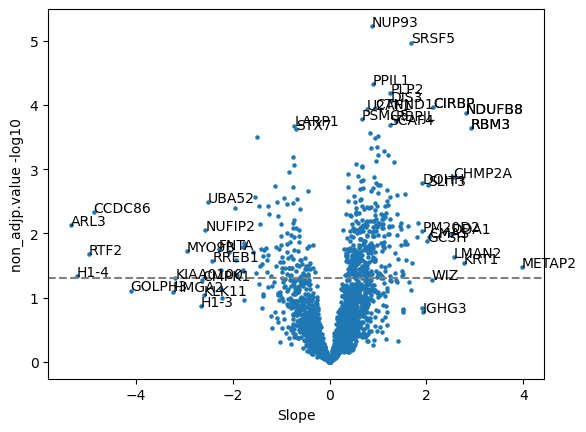

In [16]:
df_linregress.reset_index(inplace = True)

# Plot all the protein from their slope value
## Plot, after convertion  y to log10(pvalue)
top_pvalue = df_linregress.sort_values(by='pvalue', ascending=True).head(15)
top_neg_slope = df_linregress.sort_values(by='slope', ascending=True).head(15)
top_pos_slope = df_linregress.sort_values(by='slope', ascending=False).head(15)

plt.scatter(x=df_linregress['slope'], y=df_linregress['pvalue'].apply(lambda x:-numpy.log10(x)),s=5)

plt.xlabel("Slope")
plt.ylabel("non_adjp.value -log10")

# Annotate points on the plot with Symbol names
for index, row in top_pvalue.iterrows():
    plt.annotate(row['Gene'], (row['slope'], -numpy.log10(row['pvalue'])),
                fontsize = 10)
    
for index, row in top_neg_slope.iterrows():
    plt.annotate(row['Gene'], (row['slope'], -numpy.log10(row['pvalue'])),
                fontsize = 10)
    
for index, row in top_pos_slope.iterrows():
    plt.annotate(row['Gene'], (row['slope'], -numpy.log10(row['pvalue'])),
                fontsize = 10)
    
# pvalue <0.05
plt.axhline(-numpy.log10(0.05),color="grey",linestyle="--")

# title_file = 'volcano_proteomic_slope'
# plt.savefig(file_directory+'3) output/Proteomics/'+title_file+'.svg')

## Check if our known targets are well affected at 32°C

In [17]:
# Select the targets and only select expression columns
df_targets =  df[ (df.index == 'CIRBP') | (df.index == 'RBM3') | (df.index == 'SMYD5')]
df_targets

,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,9h_BR2,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3
Gene,,,,,,,,,,,,,,,,,,
CIRBP,79.2,101.4,88.4,78.7,92.5,96.6,86.9,84.4,94.5,96.3,95.7,113.2,126.1,113.9,98.2,114.9,121.1,117.9
RBM3,80.3,90.6,85.4,79.8,85.5,94.5,88.8,83.5,98.6,102.3,98.5,102.7,104.8,88.9,121.1,127.3,104.0,163.3
SMYD5,101.6,100.2,111.3,119.4,121.4,98.9,95.0,119.9,101.0,82.8,107.0,100.5,96.7,98.9,91.0,78.6,81.2,94.7


    Gene conditions  value
0  CIRBP       Ctrl   79.2
1   RBM3       Ctrl   80.3
2  SMYD5       Ctrl  101.6
3  CIRBP       Ctrl  101.4
4   RBM3       Ctrl   90.6, 

      Gene     slope    rvalue    pvalue
54   CIRBP  2.145201  0.786152  0.000110
99    RBM3  2.922497  0.762776  0.000232
147  SMYD5 -1.431476 -0.610296  0.007150


C:\Users\kja11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kja11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


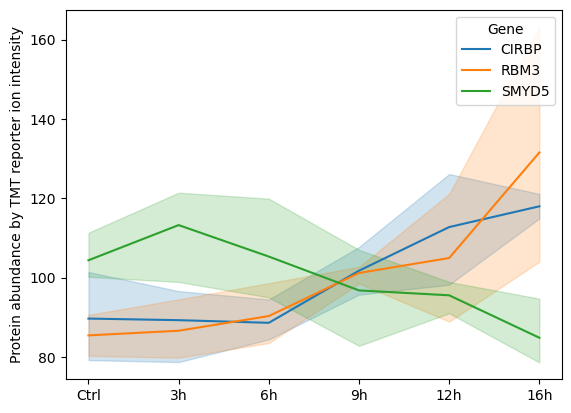

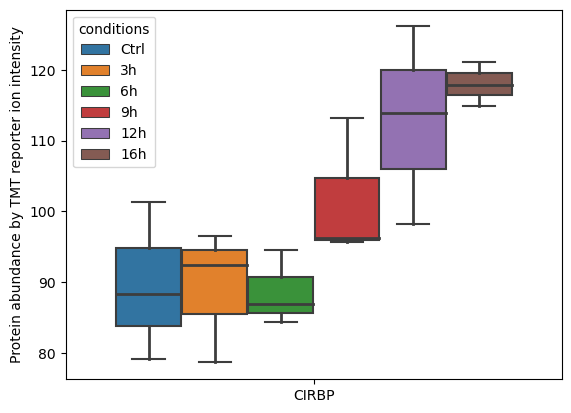

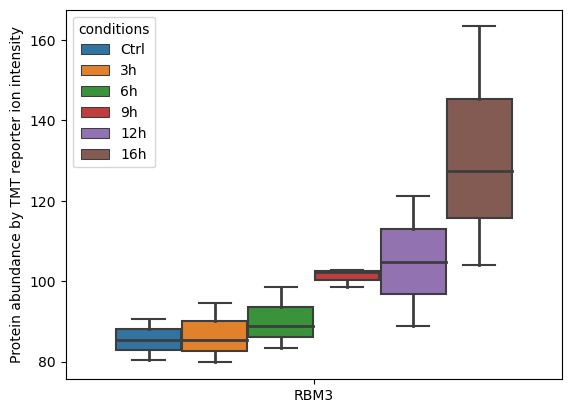

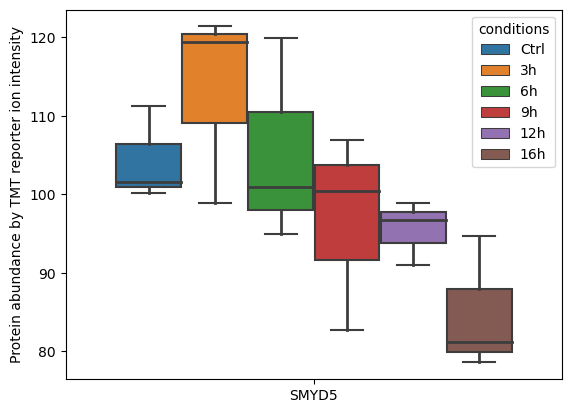

In [18]:
# From Wide to Long table
df_targets = df_targets.reset_index()
df_targets = df_targets.melt(id_vars=["Gene"], var_name="conditions")

## pull the technical triplicate
df_targets['conditions'] = df_targets['conditions'].str.split('_').str[0]
print(f'{df_targets.head()}, \n')

# Print linregess results for the targets
print(df_linregress[(df_linregress['Gene'] == 'CIRBP')|(df_linregress['Gene'] == 'RBM3')
                    |(df_linregress['Gene'] == 'SMYD5')])

seaborn.lineplot(data = df_targets, x='conditions' , y='value', hue= "Gene")
plt.ylabel("Protein abundance by TMT reporter ion intensity")
plt.xlabel("")
plt.show()
plt.close()

# Expression of the target proteins over time
targets = ['CIRBP', 'RBM3', 'SMYD5']

for target in targets:
    df_plt = df_targets[df_targets['Gene'] == target]
    seaborn.boxplot(df_plt, y = 'value', x = 'Gene', hue = 'conditions', 
                medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
    
    plt.ylabel("Protein abundance by TMT reporter ion intensity")
    plt.xlabel("")
    plt.show()
    plt.close()

## Overlap with RNAseq

The overlapping targets are CHORDC1, CIRBP, SRSF5, RBM3 and HNRNPDL

In [19]:
# Select the overlapping targets and only select expression columns
df_targets =  df[ (df.index == 'CIRBP') | (df.index == 'RBM3') | (df.index == 'SRSF5')
                 | (df.index == 'HNRNPDL') | (df.index == 'CHORDC1')]

df_targets

,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,9h_BR2,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3
Gene,,,,,,,,,,,,,,,,,,
SRSF5,87.4,99.4,89.2,78.1,98.1,96.5,96.9,93.8,90.1,100.6,96.5,105.3,102.4,106.6,114.4,109.9,116.7,117.8
CIRBP,79.2,101.4,88.4,78.7,92.5,96.6,86.9,84.4,94.5,96.3,95.7,113.2,126.1,113.9,98.2,114.9,121.1,117.9
CHORDC1,99.4,103.0,109.1,95.9,110.9,107.1,97.3,101.1,103.8,100.6,108.4,100.7,102.2,92.2,92.7,90.1,96.3,89.2
RBM3,80.3,90.6,85.4,79.8,85.5,94.5,88.8,83.5,98.6,102.3,98.5,102.7,104.8,88.9,121.1,127.3,104.0,163.3
HNRNPDL,100.8,98.6,94.6,95.6,98.7,101.2,96.1,96.9,98.5,97.8,102.2,103.6,96.5,103.8,97.5,109.4,101.9,106.2


      Gene conditions  value
0    SRSF5       Ctrl   87.4
1    CIRBP       Ctrl   79.2
2  CHORDC1       Ctrl   99.4
3     RBM3       Ctrl   80.3
4  HNRNPDL       Ctrl  100.8, 

Empty DataFrame
Columns: [Gene, slope, rvalue, pvalue]
Index: []


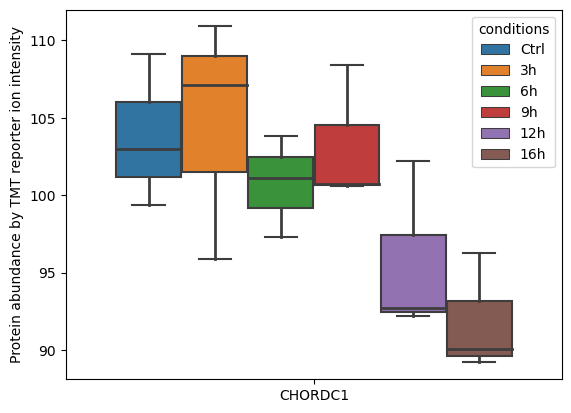

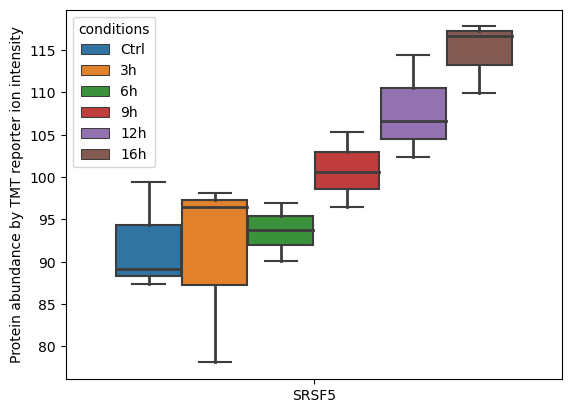

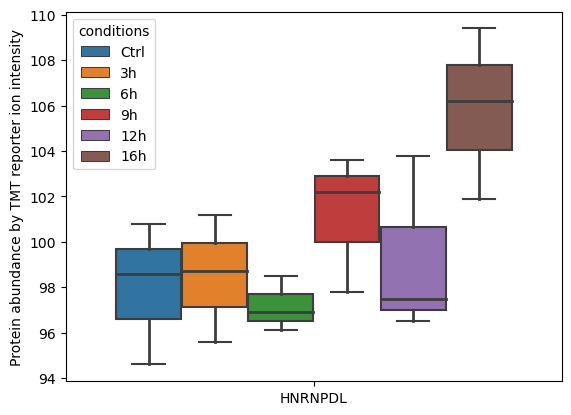

In [20]:
# Protein expression over time of the overlapped proteins.
## From Wide to Long table
df_targets = df_targets.reset_index()
df_targets = df_targets.melt(id_vars=["Gene"], var_name="conditions")

## pull the technical triplicate
df_targets['conditions'] = df_targets['conditions'].str.split('_').str[0]
print(f'{df_targets.head()}, \n')

## Print linregess results for the targets
print(df_linregress[(df_linregress.index == 'CIRBP')|(df_linregress.index == 'RBM3')|(df_linregress.index == 'SMYD5')])


## Expression of the target proteins over time
# targets = ['CHORDC1', 'CIRBP', 'SRSF5', 'RBM3', 'HNRNPDL']
targets = ['CHORDC1', 'SRSF5', 'HNRNPDL']

for target in targets:
    df_plt = df_targets[df_targets['Gene'] == target]
    seaborn.boxplot(df_plt, y = 'value', x = 'Gene', hue = 'conditions', 
                medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
    
    plt.ylabel("Protein abundance by TMT reporter ion intensity")
    plt.xlabel("")
    plt.show()
    plt.close()

## Heatmap from expression

### Heatmap all proteins

In [21]:
## pull the technical triplicate
df_zscore.columns = df_zscore.columns.str.split('_').str[0]
df_zscore.columns

Index(['Ctrl', 'Ctrl', 'Ctrl', '3h', '3h', '3h', '6h', '6h', '6h', '9h', '9h',
       '9h', '12h', '12h', '12h', '16h', '16h', '16h'],
      dtype='object')

In [22]:
print(df_zscore.min().min())
print(df_zscore.max().max())

-6.087292339666861
16.57865800691875


In [23]:
# Count number of cells in specific interval to select heatmap vmin/vmax
## Flatten the DataFrame to a 1D array
values = df_zscore.values.flatten()

bin_edges = numpy.arange(-8, 18, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})

print(count_df)

    Interval  Count
0   -8 to -7      0
1   -7 to -6      2
2   -6 to -5     14
3   -5 to -4     42
4   -4 to -3    152
5   -3 to -2    674
6   -2 to -1   3980
7    -1 to 0  17465
8     0 to 1  16050
9     1 to 2   3810
10    2 to 3    747
11    3 to 4    212
12    4 to 5     63
13    5 to 6     29
14    6 to 7     18
15    7 to 8     12
16    8 to 9      5
17   9 to 10      5
18  10 to 11      2
19  11 to 12      3
20  12 to 13      1
21  13 to 14      0
22  14 to 15      2
23  15 to 16      1
24  16 to 17      1


number of proteins: 2405


C:\Users\kja11\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


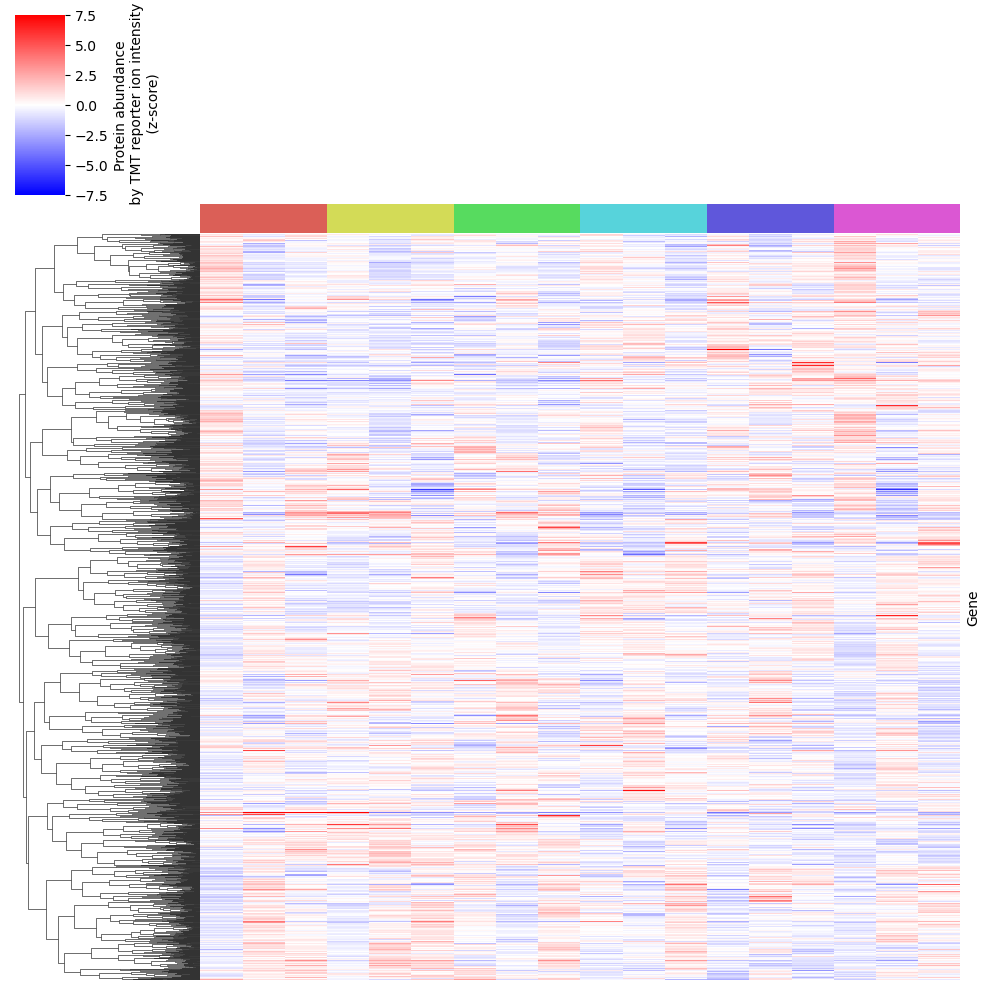

In [24]:
# Heatmap of all proteins expression 
## define the colors, one color per condition 
lut = dict(zip(df_zscore.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_zscore.columns.map(lut)

## plot heatmap
linkage_method = 'complete'
distance_metric = 'cosine'

print('number of proteins:', len(df_zscore))
clustergrid = seaborn.clustermap(df_zscore,
                                 cmap='bwr', 
                                 row_cluster=True, 
                                 col_cluster=False, 
                                 vmin=-7.5, vmax=7.5,
                                 col_colors = col_colors_conditions,
                                 cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                                 xticklabels=False, yticklabels=False, 
                                 method=linkage_method, metric=distance_metric)


### Heatmap Linregress significant proteins only

In [25]:
# Count number of cells in specific interval to select heatmap vmin/vmax
values = df_zscore[df_zscore.index.isin(signif_linregress_proteins)].values.flatten()
bin_edges = numpy.arange(-7, 17, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
# print(count_df.head(3), '\n', count_df.tail(10))
print(count_df)

    Interval  Count
0   -7 to -6      0
1   -6 to -5      6
2   -5 to -4     14
3   -4 to -3     42
4   -3 to -2    115
5   -2 to -1    793
6    -1 to 0   3183
7     0 to 1   2930
8     1 to 2    671
9     2 to 3    143
10    3 to 4     53
11    4 to 5     14
12    5 to 6      8
13    6 to 7      7
14    7 to 8      5
15    8 to 9      2
16   9 to 10      2
17  10 to 11      1
18  11 to 12      1
19  12 to 13      0
20  13 to 14      0
21  14 to 15      1
22  15 to 16      1


number of proteins: 444


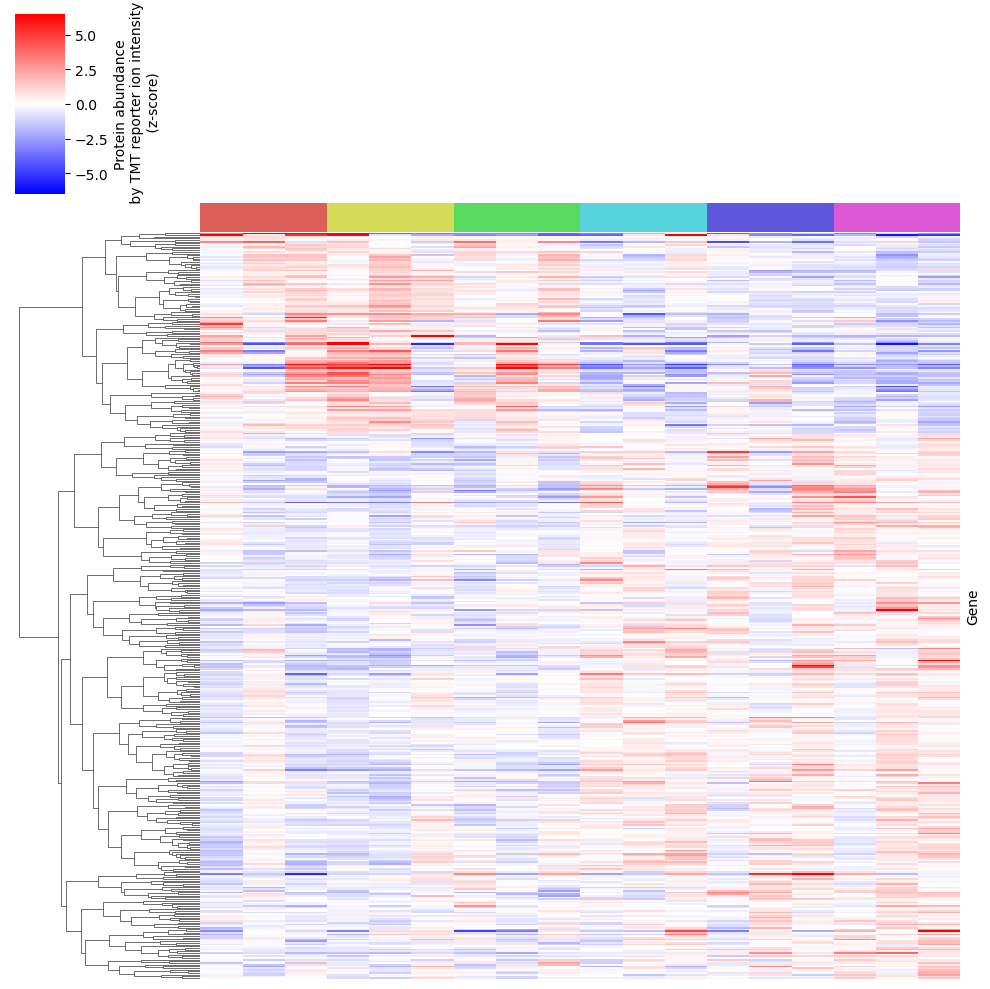

In [26]:
# Same but with Linregress significant only
## define the colors, one color per condition 
lut = dict(zip(df_zscore.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_zscore.columns.map(lut)

## plot heatmap
print('number of proteins:', len(df_zscore[df_zscore.index.isin(signif_linregress_proteins)]))

seaborn.clustermap(df_zscore[df_zscore.index.isin(signif_linregress_proteins)], 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=False, 
                   vmin=-6.5, vmax=6.5,
                   col_colors = col_colors_conditions,
                   cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                   xticklabels=False, yticklabels=False, 
                   method='complete', metric='cosine')

### Heatmap with proteins slope with rvalue > 0.6 (abs)

In [27]:
# Count number of cells in specific interval to select heatmap vmin/vmax
df_high_Rval = df_zscore[df_zscore.index.isin(high_Rval_prot)]
print(len(df_high_Rval))

values = df_high_Rval.values.flatten()
bin_edges = numpy.arange(-8, 12, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
print(count_df)

147
    Interval  Count
0   -8 to -7      0
1   -7 to -6      0
2   -6 to -5      1
3   -5 to -4      3
4   -4 to -3      7
5   -3 to -2     23
6   -2 to -1    258
7    -1 to 0   1087
8     0 to 1    991
9     1 to 2    216
10    2 to 3     39
11    3 to 4      8
12    4 to 5      2
13    5 to 6      2
14    6 to 7      4
15    7 to 8      1
16    8 to 9      1
17   9 to 10      2
18  10 to 11      1


number of proteins: 147


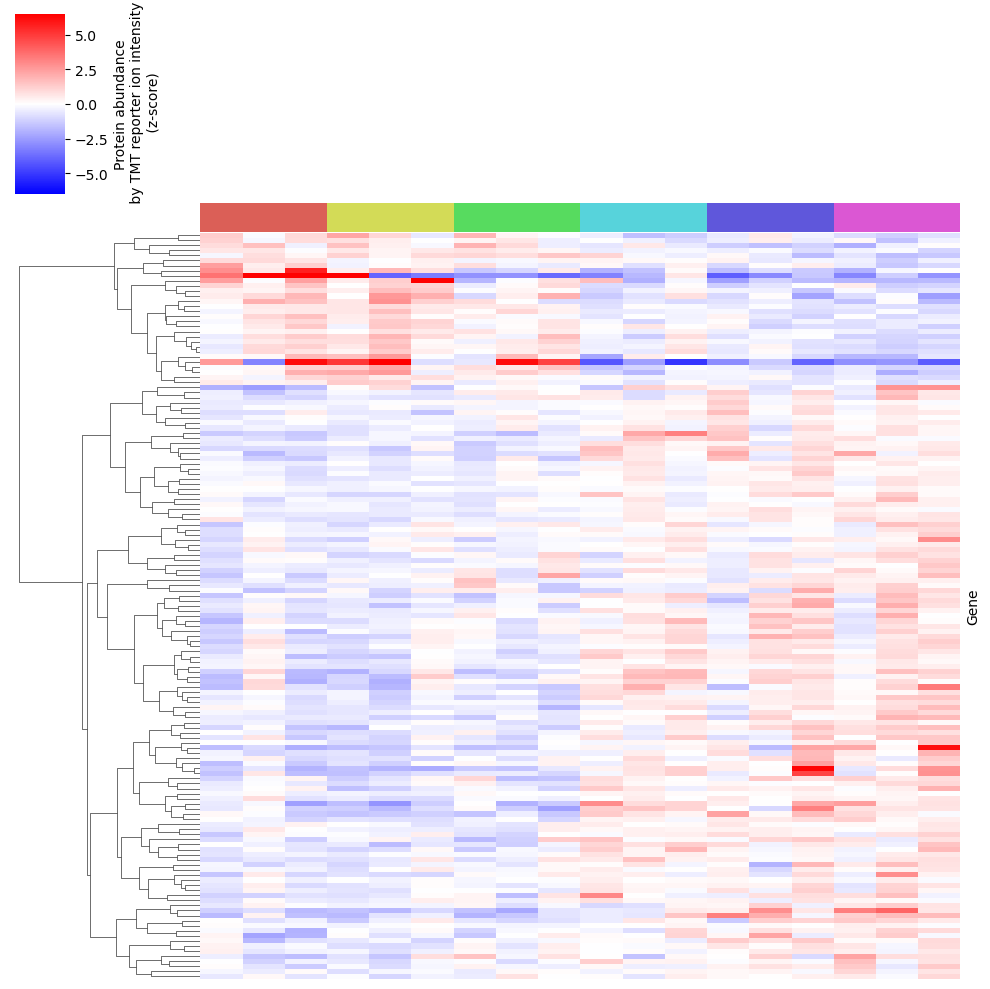

In [28]:
# Heatmap of proteins slove with rvalue > 0.6
## define the colors, one color per condition 
lut = dict(zip(df_high_Rval.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_high_Rval.columns.map(lut)

## plot heatmap
print('number of proteins:', len(high_Rval_prot))
seaborn.clustermap(df_high_Rval, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=False, 
                   vmin=-6.5, vmax=6.5,
                   col_colors = col_colors_conditions,
                   cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                   xticklabels=False, yticklabels=False, 
                   method='complete', metric='cosine')

In [29]:
# Same with mean instead of the separate triplicate
## Have mean of the triplicate
df_high_Rval_mean = df_high_Rval.assign(_ctl= (df_high_Rval[['Ctrl']].mean(axis=1)),
                   _3h= (df_high_Rval[['3h']].mean(axis=1)),
                   _6h= (df_high_Rval[['6h']].mean(axis=1)),
                   _9h= (df_high_Rval[['9h']].mean(axis=1)),
                   _12h= (df_high_Rval[['12h']].mean(axis=1)),
                   _16h= (df_high_Rval[['16h']].mean(axis=1)))

df_high_Rval_mean = df_high_Rval_mean.iloc[:,-6:]
print(df_high_Rval_mean)

            _ctl       _3h       _6h       _9h      _12h      _16h
Gene                                                              
DIS3   -0.615968 -0.608018 -1.049398  0.561418  0.440607  0.994354
LARP1   0.377579  0.696883  0.491565 -0.282963 -0.454059 -0.682781
NUP93  -0.434633 -0.565996 -0.421472  0.282040  0.443702  0.557071
NDUFB8 -1.275113 -1.457317 -1.463756 -0.171357  1.320614  2.619555
CTNND1 -0.466137 -0.336538 -0.486083  0.043638  0.218794  0.864073
...          ...       ...       ...       ...       ...       ...
MCM3   -0.286092 -0.182113 -0.302130  0.033980  0.450732  0.454144
MCM4   -0.346856 -0.260086 -0.122158  0.227220  0.641181  0.211519
EIF2S3 -0.374001 -0.010181  0.028010  0.147685 -0.027703  0.403911
PUF60  -0.276211 -0.075066 -0.094462  0.123027 -0.044007  0.374865
MAP2K5 -0.740408 -0.389040 -0.322753  0.493035  0.364761  0.500050

[147 rows x 6 columns]


In [30]:
print(df_high_Rval_mean.min().min())
print(df_high_Rval_mean.max().max(), '\n')

# Count number of cells in specific interval to select heatmap vmin/vmax
values = df_high_Rval_mean.values.flatten()
bin_edges = numpy.arange(-5, 11, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
print(count_df, '\n')

-3.946333208331801
7.708189112006299 

    Interval  Count
0   -5 to -4      0
1   -4 to -3      3
2   -3 to -2      4
3   -2 to -1     46
4    -1 to 0    397
5     0 to 1    384
6     1 to 2     40
7     2 to 3      3
8     3 to 4      3
9     4 to 5      1
10    5 to 6      0
11    6 to 7      0
12    7 to 8      1
13    8 to 9      0
14   9 to 10      0 



number of proteins: 147


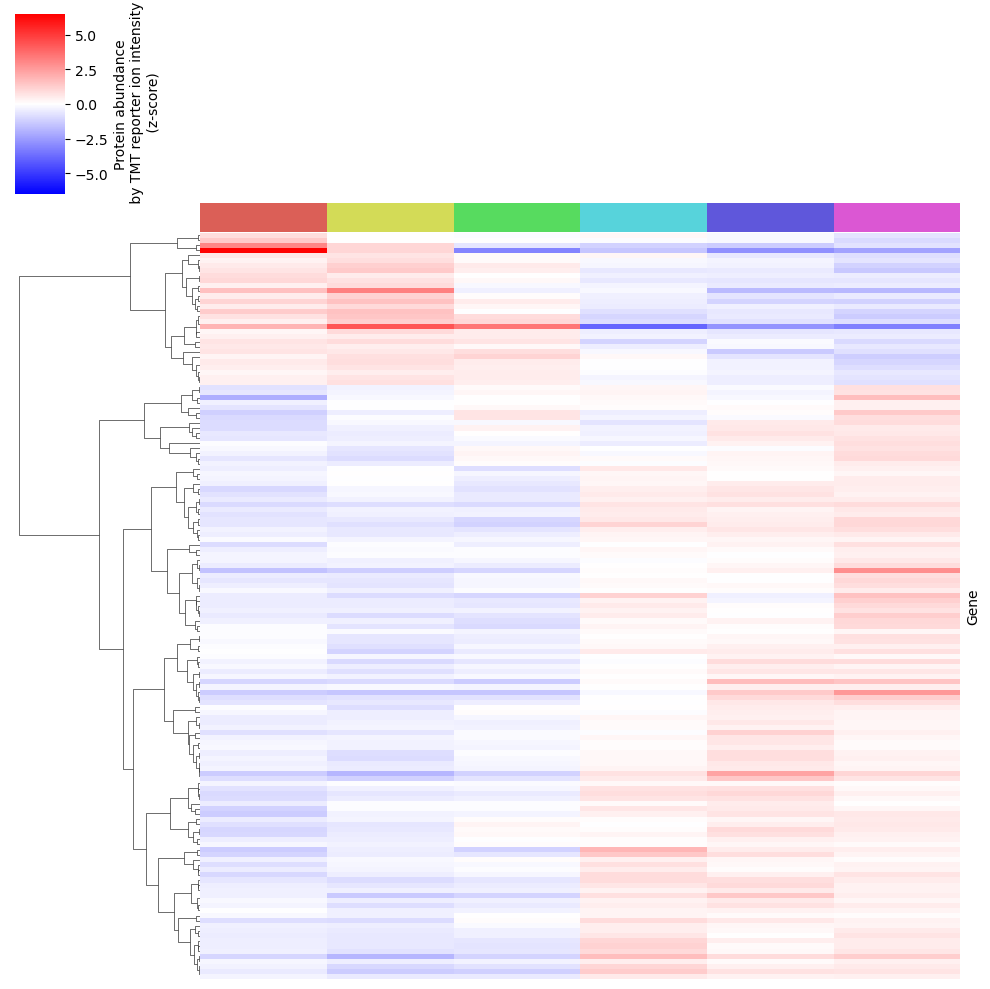

In [31]:
# Heatmap of proteins slove with rvalue > 0.6
## define the colors, one color per condition 
lut = dict(zip(df_high_Rval_mean.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_high_Rval_mean.columns.map(lut)

## plot heatmap
print('number of proteins:', len(df_high_Rval_mean))
seaborn.clustermap(df_high_Rval_mean, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=False, 
                   vmin=-6.5, vmax=6.5,
                   col_colors = col_colors_conditions,
                   cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                   xticklabels=False, yticklabels=False, 
                   method='complete', metric='cosine')

<Axes: ylabel='Gene'>

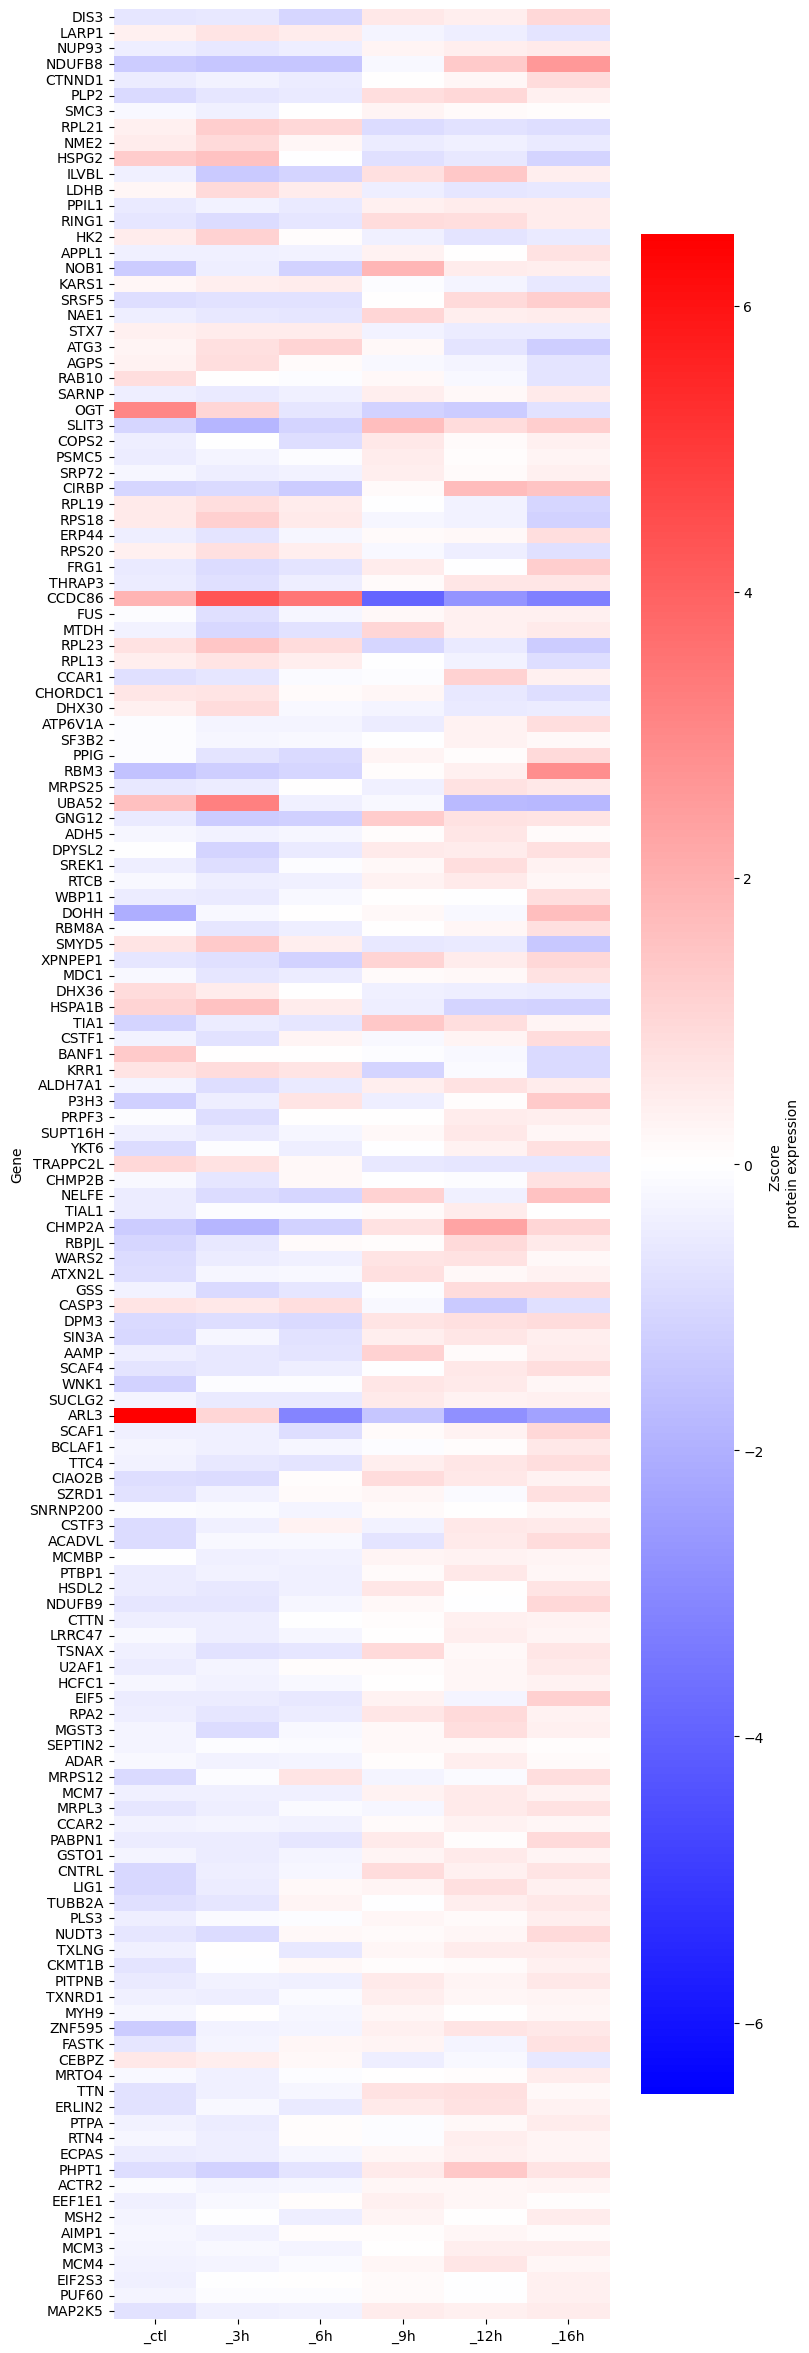

In [32]:
# For more detail but not clustered
plt.subplots(figsize=(8, 30))
# plt.tight_layout()
seaborn.heatmap(df_high_Rval_mean, annot=False, cmap="bwr", linewidths=0, center=0, vmin=-6.5, vmax=6.5,
               cbar_kws={'label': 'Zscore \n protein expression'})

## Heatmap from Slope

In [33]:
df_linregress_high_Rval = df_linregress[df_linregress['Gene'].isin(high_Rval_prot)]
len(df_linregress_high_Rval)
df_linregress_high_Rval.head(2)

,Gene,slope,rvalue,pvalue
0,DIS3,1.267183,0.792792,0.000087
1,LARP1,-0.725181,-0.766185,0.000209


In [34]:
print(df_linregress_high_Rval.slope.min())
print(df_linregress_high_Rval.slope.max(), '\n')

# Count number of cells in specific interval to select heatmap vmin/vmax
values = df_linregress_high_Rval.slope
bin_edges = numpy.arange(-6, 5, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
print(count_df, '\n')

-5.340041279669763
2.9224974200206404 

   Interval  Count
0  -6 to -5      1
1  -5 to -4      1
2  -4 to -3      0
3  -3 to -2      1
4  -2 to -1     10
5   -1 to 0     17
6    0 to 1     70
7    1 to 2     42
8    2 to 3      5
9    3 to 4      0 



In [35]:
# Prepare data for heatmap
df_linregress_high_Rval.set_index('Gene', inplace=True)
df_linregress_high_Rval = df_linregress_high_Rval.iloc[:,:1]
df_linregress_high_Rval = df_linregress_high_Rval.sort_values(['slope'], ascending = True)
df_linregress_high_Rval.head()

,slope
Gene,
ARL3,-5.340041
CCDC86,-4.868318
UBA52,-2.517234
OGT,-1.950877
RPL23,-1.542724


number of proteins: 147


<Axes: ylabel='Gene'>

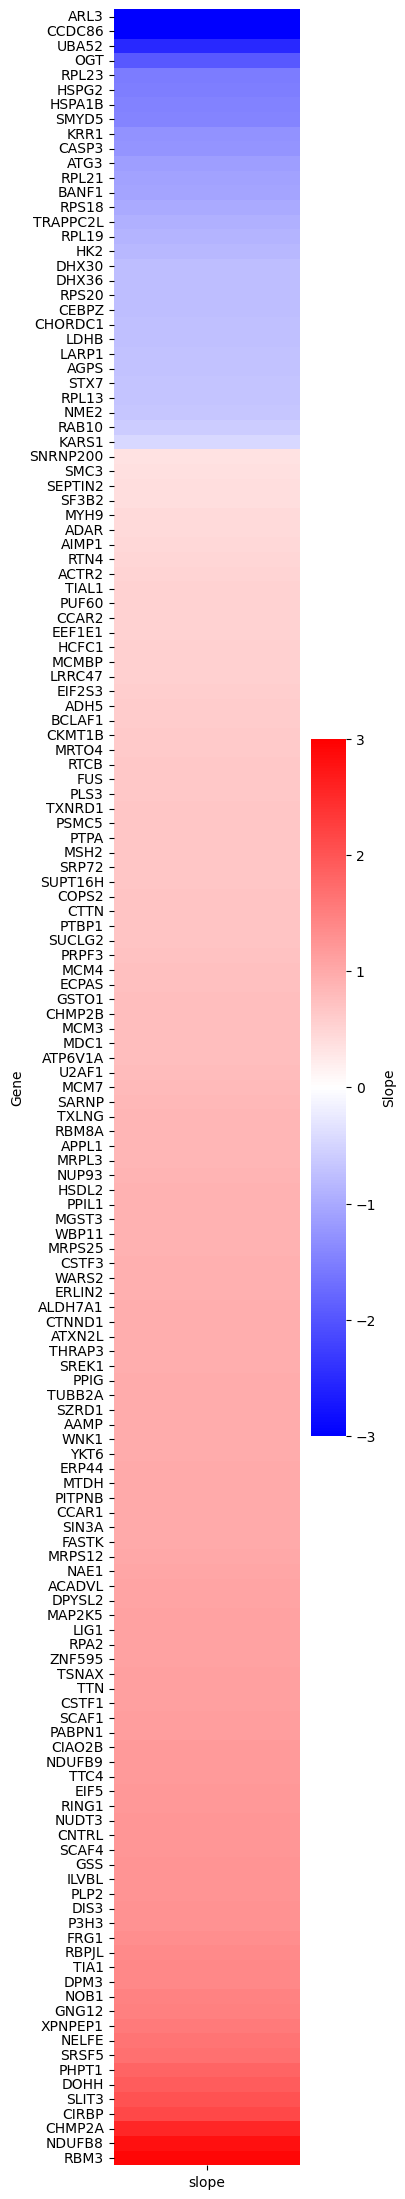

In [36]:
# plot heatmap
print('number of proteins:', len(df_linregress_high_Rval))
plt.subplots(figsize=(3, 28))

seaborn.heatmap(df_linregress_high_Rval, annot=False, cmap="bwr", 
                linewidths=0, center=0, vmin=-3, vmax=3, cbar_kws={'label': 'Slope'})

## Plot line for the 20 top and 20 top neg

In [37]:
# select the top 20 up and down
top_neg_20 = df_linregress_high_Rval.iloc[:20,:].index
top_20 = df_linregress_high_Rval.iloc[-20:,:].index

In [38]:
# moving average smoothing
df_smoothed_top = df_high_Rval_mean[df_high_Rval_mean.index.isin(top_20)].T.rolling(window=3, min_periods=1).mean()
df_smoothed_neg_top = df_high_Rval_mean[df_high_Rval_mean.index.isin(top_neg_20)].T.rolling(window=3, min_periods=1).mean()

In [39]:
## normalization Positive
shift = df_smoothed_top.mean()
general_mean = df_smoothed_top.mean().mean()
relative_mu = shift/general_mean

normalized_data = df_smoothed_top/relative_mu

## normalization Negative
shift = df_smoothed_neg_top.mean()
general_mean = df_smoothed_neg_top.mean().mean()
relative_mu = shift/general_mean

normalized_data_neg = df_smoothed_neg_top/relative_mu

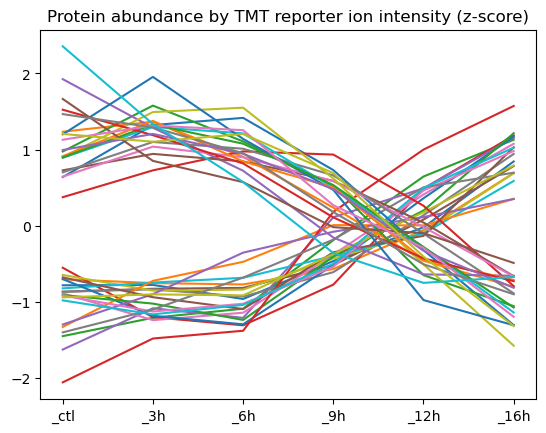

In [41]:
# LinePlot 
plt.plot(normalized_data)
plt.plot(normalized_data_neg)
plt.title("Protein abundance by TMT reporter ion intensity (z-score)")
plt.show()